In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol 
    #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    #data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
data = run('NQ', roca, output=True)

weights: 
roc_5      0.198858
roc_10     0.159565
roc_20     0.149420
roc_40     0.149113
roc_80     0.159349
roc_160    0.183695

adjustments:
roc_5      12.204481
roc_10     20.907997
roc_20     29.422486
roc_40     43.022924
roc_80     60.110786
roc_160    83.086371

multiplier:
1.1624340117965826

correlations:
            roc_5    roc_10    roc_20    roc_40    roc_80   roc_160
roc_5    1.000000  0.860052  0.690009  0.502624  0.366179  0.259831
roc_10   0.860052  1.000000  0.938201  0.766178  0.589879  0.430266
roc_20   0.690009  0.938201  1.000000  0.922802  0.764114  0.580727
roc_40   0.502624  0.766178  0.922802  1.000000  0.936701  0.777620
roc_80   0.366179  0.589879  0.764114  0.936701  1.000000  0.933907
roc_160  0.259831  0.430266  0.580727  0.777620  0.933907  1.000000

simulation start date: 2019-01-01 00:00:00


In [11]:
calibrate_multiple('NQ', roca, )

(roc_5      0.200675
 roc_10     0.159745
 roc_20     0.149269
 roc_40     0.149032
 roc_80     0.159282
 roc_160    0.181996
 dtype: float64, roc_5      13.023485
 roc_10     22.106007
 roc_20     30.977160
 roc_40     45.133820
 roc_80     63.373033
 roc_160    89.785895
 dtype: float64, 1.1626858476390332)

In [12]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.680434182405847, 5.828855632901552)

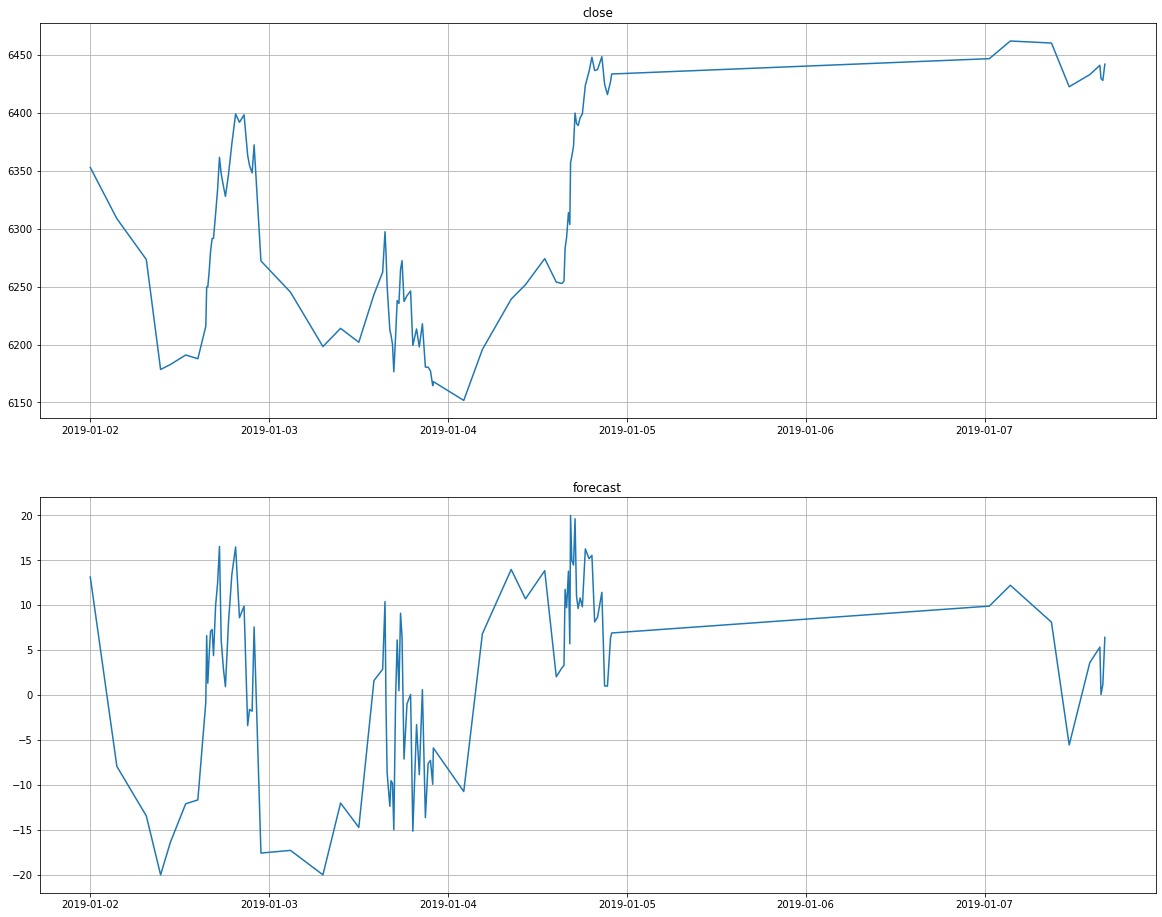

In [13]:
plot(data[['close', 'forecast']].iloc[:100])

In [14]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.00777177,0.118021,0.131117,0.0842944,0.107792,0.179709,0.158388,0.190963,0.147609
Cumulative returns,0.00545245,0.0815092,0.0903918,0.05849,0.0745499,0.123087,0.108791,0.130601,0.101535
Annual volatility,0.201828,0.163508,0.146173,0.138346,0.137823,0.115883,0.0731537,0.0562435,0.0479369
Sharpe ratio,0.138906,0.763667,0.915696,0.653803,0.811457,1.4842,2.04671,3.13619,2.89665
Calmar ratio,0.0831558,1.48053,2.00539,0.989908,1.02887,2.16893,6.17269,10.1398,10.1566
Stability,0.174167,0.645187,0.654756,0.320853,0.289247,0.469096,0.833573,0.901207,0.921982
Max drawdown,-0.0934604,-0.079715,-0.0653821,-0.0851538,-0.104768,-0.082856,-0.0256595,-0.0188331,-0.0145333
Omega ratio,1.02338,1.13278,1.16836,1.11398,1.14795,1.30624,1.52952,2.02686,2.13994
Sortino ratio,0.19274,1.14416,1.38865,0.985677,1.20985,2.3443,3.77568,6.33751,6.233
Skew,-0.22154,0.0728778,0.0619293,0.0854339,-0.117249,0.0243798,0.871993,1.09651,1.62489


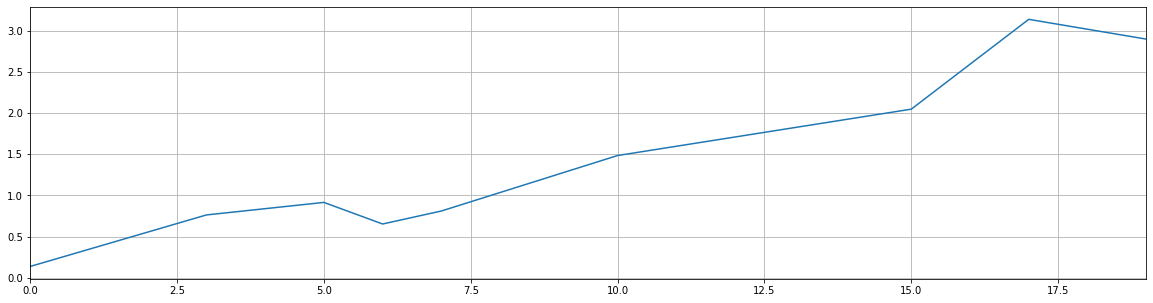

In [15]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [16]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.904339,0.839936,0.810940,0.763861,0.678350,0.472308,0.356612,0.236315
3,0.904339,1.000000,0.926147,0.884116,0.822218,0.685410,0.451159,0.341075,0.216268
5,0.839936,0.926147,1.000000,0.944404,0.880181,0.756445,0.508119,0.407547,0.282419
6,0.810940,0.884116,0.944404,1.000000,0.943050,0.800997,0.558188,0.460695,0.330287
7,0.763861,0.822218,0.880181,0.943050,1.000000,0.850904,0.583309,0.477573,0.322397
10,0.678350,0.685410,0.756445,0.800997,0.850904,1.000000,0.632903,0.496729,0.304175
15,0.472308,0.451159,0.508119,0.558188,0.583309,0.632903,1.000000,0.806898,0.572026
17,0.356612,0.341075,0.407547,0.460695,0.477573,0.496729,0.806898,1.000000,0.689525
19,0.236315,0.216268,0.282419,0.330287,0.322397,0.304175,0.572026,0.689525,1.000000


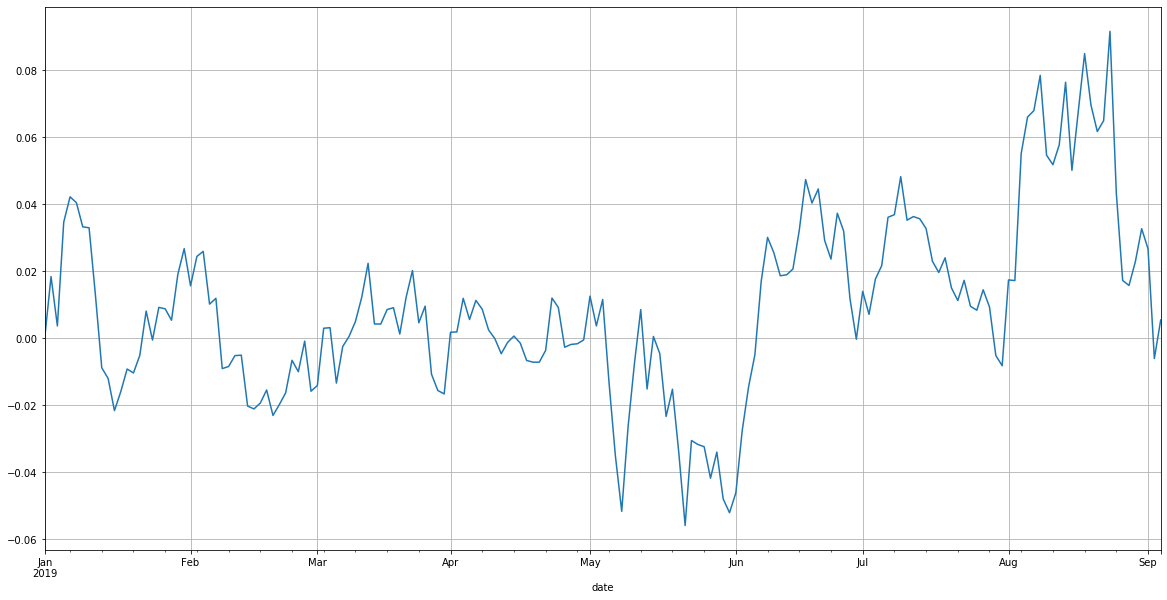

In [17]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

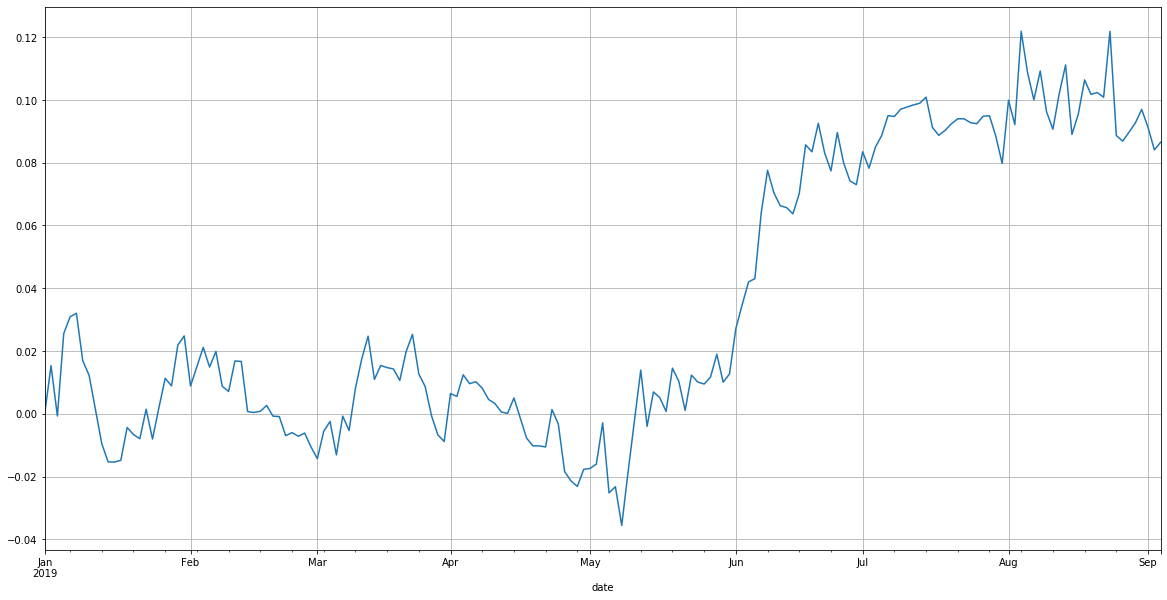

In [18]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

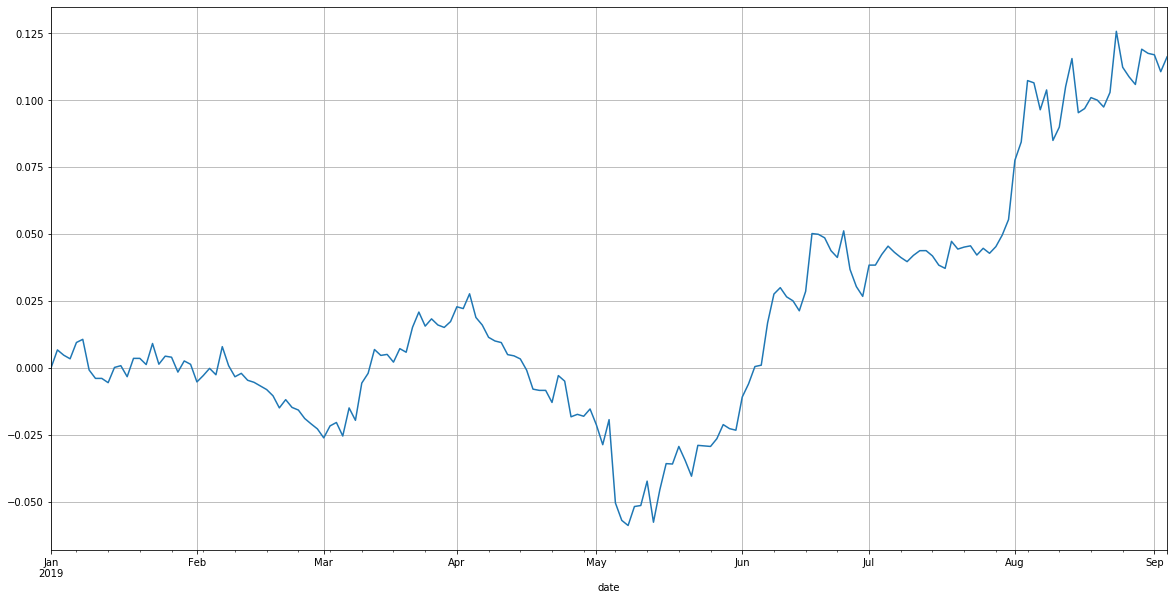

In [19]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);